# Mel Spectrogram Convolutional Neural Network

Below we build and assess a convolutional neural network that uses the Mel Spectrogram image data to predict the sound class: cough, laughter, sigh, sneeze, sniff, and throat clear.

An important note is that this code was run on [kaggle](kaggle.com) to use its public GPU. This means the directories in which this notebook pulls from and saves to are specific to kaggle. If you run this notebook on your local machine use the paths to the `melspecs.npy` and `speaker_data_and_target.csv` that were generated in the previous notebook.

---

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2

---

## Train-Val-Test Split

First let us load in our Mel Spectrogram numpy array and the label data.

The label the `sound` is contained in the `speaker_data` dataframe, alongside information about each contributor to the audio dataset. Aside from the labels, `speaker_data` contains the sex, age, country, and language of the contributor. This will be interesting to look into later and see if these factors seem to impact the our model's performance.

In [2]:
# directories are through Kaggle, update these paths to where you placed the Mel Spectrogram array and speaker_data_and_target.csv
# that were generated in the previous notebook
melspec = np.load('../input/mel-spectrogram-data/melspecs.npy')
speaker_data = pd.read_csv('../input/speaker-data-and-target/speaker_data_and_target.csv')

A necessary step for preprocessing our Mel Spectrogram image data is we need an axis depicting that the pixel values should be read as greyscale. We can accomplish this with `np.newaxis`.

In [3]:
speaker_data.head()

,id,sound,sex,age,country,language
0,f0003,0,female,56,United States of America,EN
1,f0003,1,female,56,United States of America,EN
2,f0003,2,female,56,United States of America,EN
3,f0003,3,female,56,United States of America,EN
4,f0003,4,female,56,United States of America,EN


In [4]:
X = melspec[..., np.newaxis]
y = speaker_data['sound']

Next we split our dataset into a training, validation, and test set. The validation data will be used to just our model across each epoch and make adjustments to the architecture of the neural network. The testing set will serve as genuinely unseen data.

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                            test_size = 0.15,
                                                            stratify = y,
                                                            random_state = 42)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                 test_size = 0.15,
                                                 stratify = y_train_val,
                                                 random_state = 42)

---

## CNN

After several refinements, the architecture below led to one of our better performing models. This model contains several convolutional, max pooling, and dense layers. There is also some regularization in the form of Dropout and L2 regularization. Batch normalization is included for training efficiency.

In [7]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size= (3,3),
                 activation = 'relu', padding = 'same',
                 input_shape = (40,259,1), kernel_regularizer= l2(0.001)))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size= (3,3), activation = 'relu', padding = 'same', kernel_regularizer= l2(0.001)))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size= (3,3), activation = 'relu', padding = 'same', kernel_regularizer= l2(0.001)))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size= (3,3), activation = 'relu', padding = 'same', kernel_regularizer= l2(0.001)))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(32, activation = 'relu', kernel_regularizer= l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(32, activation = 'relu', kernel_regularizer= l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(32, activation = 'relu', kernel_regularizer= l2(0.001)))
model.add(Dropout(0.2))

model.add(Dense(6, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

2022-11-14 22:14:23.164848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 22:14:23.271936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 22:14:23.272839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 22:14:23.274646: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
history = model.fit(X_train, y_train, batch_size = 8, epochs = 30, validation_data = (X_val, y_val))

2022-11-14 22:14:28.445800: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 628271840 exceeds 10% of free system memory.
2022-11-14 22:14:29.170351: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 628271840 exceeds 10% of free system memory.
2022-11-14 22:14:29.696207: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-11-14 22:14:31.558275: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1896/1896 [==============================] - 19s 6ms/step - loss: 1.5597 - accuracy: 0.4733 - val_loss: 1.0364 - val_accuracy: 0.7037
Epoch 2/30
1896/1896 [==============================] - 10s 5ms/step - loss: 1.1134 - accuracy: 0.6915 - val_loss: 0.9285 - val_accuracy: 0.7560
Epoch 3/30
1896/1896 [==============================] - 11s 6ms/step - loss: 0.9683 - accuracy: 0.7670 - val_loss: 0.7684 - val_accuracy: 0.8262
Epoch 4/30
1896/1896 [==============================] - 10s 5ms/step - loss: 0.8972 - accuracy: 0.7881 - val_loss: 0.7964 - val_accuracy: 0.8229
Epoch 5/30
1896/1896 [==============================] - 10s 5ms/step - loss: 0.8692 - accuracy: 0.8036 - val_loss: 0.8411 - val_accuracy: 0.8031
Epoch 6/30
1896/1896 [==============================] - 11s 6ms/step - loss: 0.8318 - accuracy: 0.8184 - val_loss: 0.8183 - val_accuracy: 0.8244
Epoch 7/30
1896/1896 [==============================] - 10s 5ms/step - loss: 0.8445 - accuracy: 0.8165 - val_loss: 0.7472 - val_accuracy: 0.8

## Assessing the Model

First we plot the model's performance history across each epoch during training. We check both loss and accuracy on the training and validation sets.

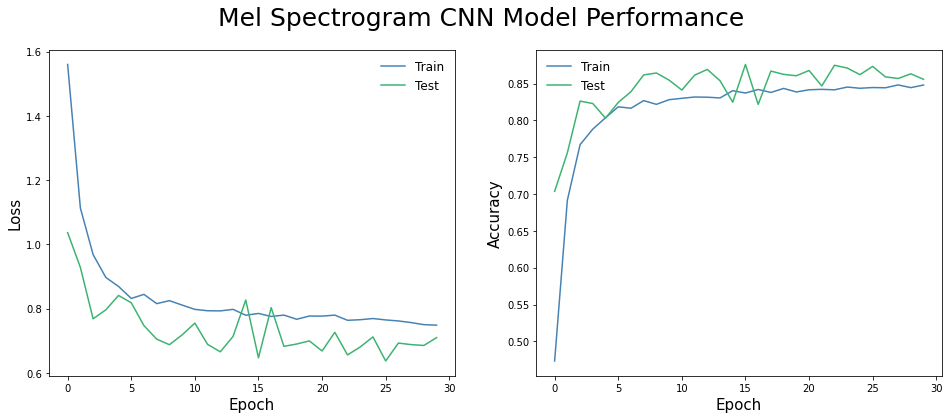

In [9]:
plt.figure(figsize = (16,6))

plt.suptitle('Mel Spectrogram CNN Model Performance', size = 25)

plt.subplot(1,2,1)
#plt.title('Loss', size = 25)
plt.xlabel('Epoch', size = 15)
plt.ylabel('Loss', size = 15)
plt.plot(history.history['loss'], color = 'steelblue', label = 'Train')
plt.plot(history.history['val_loss'], color = 'mediumseagreen', label = 'Test')
plt.legend(fontsize = 'large', frameon = False)

plt.subplot(1,2,2)
#plt.title('Accuracy', size = 25)
plt.xlabel('Epoch', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.plot(history.history['accuracy'], color = 'steelblue', label = 'Train')
plt.plot(history.history['val_accuracy'], color = 'mediumseagreen', label = 'Test')
plt.legend(fontsize = 'large', frameon = False)

plt.savefig('melspec_cnn.jpg');

The test graphs seem to fit less closely to the train and are generally less stable than the test graphs we saw in our previous notebook for the MFCCs neural network.

Like we did for our previous model, let us look at the quality of the predictions on the test data set. Our model predictions come in the form of probabilities, so we need to use `np.argmax()` to extract the index with the largest probability. This index will correspond to the sound label the model believes is present in the audio file.

In [10]:
# model's expected probability of each sound category
test_probs = model.predict(X_test)

# model's prediction (index with the highest probability value)
test_preds = np.argmax(test_probs, axis = 1)

In [11]:
print('Accuracy:', accuracy_score(y_test, test_preds))
print('Recall:', recall_score(y_test, test_preds, average = None))
print('Precision:', precision_score(y_test, test_preds, average = None))
print('F1:', f1_score(y_test, test_preds, average = None))

Accuracy: 0.8506988564167726
Recall: [0.78285714 0.82666667 0.86857143 0.91030534 0.9047619  0.8110687 ]
Precision: [0.9113082  0.9580574  0.86857143 0.78196721 0.8161512  0.80645161]
F1: [0.84221311 0.88752556 0.86857143 0.84126984 0.85817525 0.80875357]


The recall scores are highest for sneezes and sniffs, though we also see lower precision scores for these two categories. This suggests the model is predicting sneezes and sniffs more frequently than it should.

With coughs, the recall score is low but the precision is high meaning the model is a bit more careful about what it calls a cough. We see in the confusion matrix below that there are quite a few coughs that the model classifies as a sneeze or a throat clear. The throat clear makes a lot of sense and the sneeze seems a bit surprising.

Throat clearing has low recall and precision. The model seems to have trouble both with recognizing a sound is a throat clear and with labeling throat clears correctly. The F1 scores all seem pretty solid with the lowest score coming from identifying throat clears. This is unsurprising given what we noticed about the recall and precision scores for throat clears.

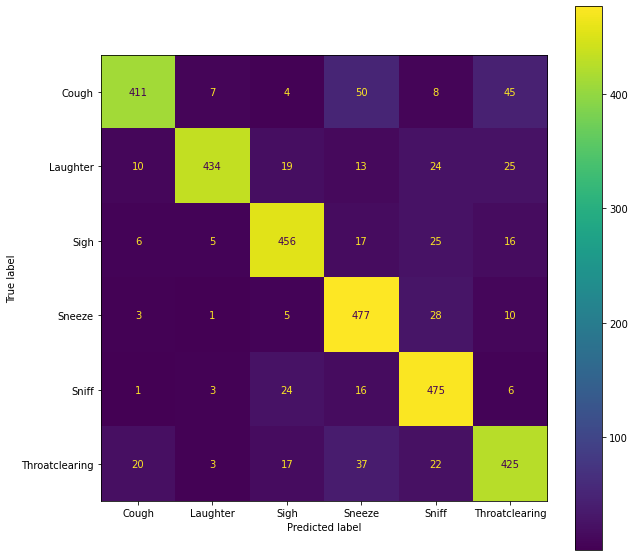

In [12]:
sound_label = ['Cough', 'Laughter', 'Sigh', 'Sneeze', 'Sniff', 'Throatclearing']

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, ax = ax, display_labels = sound_label)
plt.savefig('melspec_confusion_matrix.jpg');

## Production Model

Now that we have built and assessed two convolutional neural networks, we should choose one to use for performing future predictions. Unfortunately, the model built in this notebook involving Mel Spectrograms performed a bit worse across most metrics than the previous model built using MFCCs.

Another reason to take the neural network using MFCCs as the production is because that model performs fairly well in general and mainly makes errors when trying to distinguish coughs and throat clears. Of our six sound choices, this pair seems like the most reasonable place to make mistakes. Moreover, this Mel Spectrogram model seems to distribute the errors a bit more evenly across all sneezes, sniffs, and throat clears. These errors seem a little less reasonable.